Answer to weekly check in:

One of the things we used in our class project this week was the contact map, which mapped contacts betwen residues. In one of the more advanced problems, we also mapped hydrogen bonds. Our class project dealt with contacts and hydrogen bonds within the protein itself, but I think one nice way to relate these concepts we implemented to this simulation would be to perform new analyses and create either contact or hydrogen bonding maps between this protein and the ligands to be bound. (Maybe some sort of map between the atoms of dasatinib/PP1 with the residues or atoms of the protein). This would be interesting because we could consider which atoms of these ligands are involved with the most contacts with the allosteric binding sites and which are involved mostly with contacts within the native binding pose. This could potentially allow us to reengineer the ligand to bind more often to the native binding pose, one of the stated goals of the paper. I think it would be an interesting way to relate a concept we explored in our class project to this simulation via a new analysis.

Another concept we talked about was the concept of equilibrium, where the flux from a certain state i to another state j is equal to the flux backwards to that original state i. One thing I noticed is that their simulations each ran for around 30-40 microseconds while the bindings took place in around 0.6-15 microseconds. However, drugs can stay within the body for days. Therefore, I think it would be interesting to run an even longer simulation to see if we can reach some sort of equilibrium where the drug molecule leaves these allosteric binding sites and goes to the native binding pose and vice versa + figure out the relative populations of these states. This way, we could gauge the effectiveness of our drug molecules in a way that is more similar to the real world, where everything is on a longer timescale and equilibrium might be reached. Running this sort of simulation could possibly make this simulation even more pertinent to the very real world of drug design. 

In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a one millsecond trajectory of ubiquitin generated from DEShaw Research:

https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.6b02024

Trajectory from DESRES can be downloaded here:
https://www.dropbox.com/s/qk4winh3y66bynm/ubq.desres.s500.zip?dl=0

It can be compared to an NMR ensmeble:
https://www.wwpdb.org/pdb?id=pdb_00002kox

In [5]:
pdb='C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Ubiqutitin/ubq.pdb'
trajectory='C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Ubiqutitin/ubq.desres.s500.dcd'
outdir='C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Ubiqutitin/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Ubiqutitin/output
pdb: C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Ubiqutitin/ubq.pdb
trjaectory: C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Ubiqutitin/ubq.desres.s500.dcd


In [6]:
trj = md.load(trajectory, top=pdb,stride=2)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [7]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 1231

Number of residues: 76

Number of frames: 5044

Starting frame: 0

Last frame: 5044

sequence:  [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]

residue names:  ['MET', 'GLN', 'ILE', 'PHE', 'VAL', 'LYS', 'THR', 'LEU', 'THR', 'GLY', 'LYS', 'THR', 'ILE', 'THR', 'LEU', 'GLU', 'VAL', 'GLU', 'PRO', 'SER', 'ASP', 'THR', 'ILE', 'GLU', 'ASN', 'VAL', 'LYS', 'ALA', 'LYS', 'ILE', 'GLN', 'ASP', 'LYS', 'GLU', 'GLY', 'ILE', 'PRO', 'PRO', 'ASP', 'GLN', 'GLN', 'ARG', 'LEU', 'ILE', 'PHE', 'ALA'

In [8]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76])

In [9]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C']], dtype='<U2')

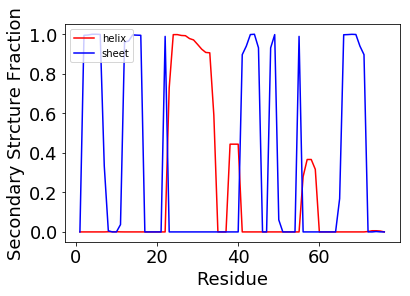

In [10]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [24 25 26 27 28 29 30 31 32 33]
SS: E [ 2  3  4  5  6 12 13 14 15 16 42 43 44 45 48 49 66 67 68 69 70]
SS: I []
SS: G []
SS: B [22 55]
SS: T [19 20 46 47 52 53 60 63 64]
SS: S []
SS:   [ 1 11 17 18 35 36 37 50 51 61 62 72 76]


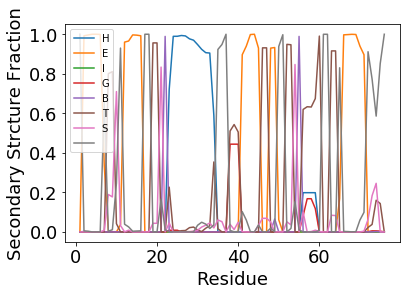

In [11]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [12]:
#Find all the frames where a given residue is H or E
residue_number=39
array_index=residue_number-0
print(np.asarray(residue_num)[array_index])
helix_frames=np.where(dssp[:,array_index]=='H')[0]
beta_frames=np.where(dssp[:,array_index]=='E')[0]

print("Residue %s"%np.asarray(residue_num)[array_index])
print("helix frames:",len(helix_frames),helix_frames)
print("beta frames:",len(beta_frames),beta_frames)

40
Residue 40
helix frames: 2239 [   1    2    3 ... 5038 5040 5043]
beta frames: 0 []


In [13]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [14]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [15]:
sequence

' [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]'

In [16]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




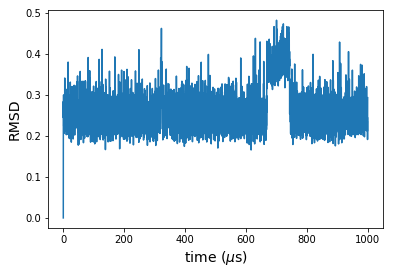

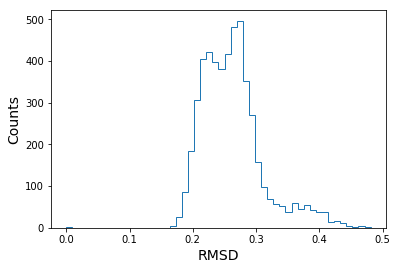

In [17]:
#Lets Calculate the RMSD and make a histogram from the starting structure 
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

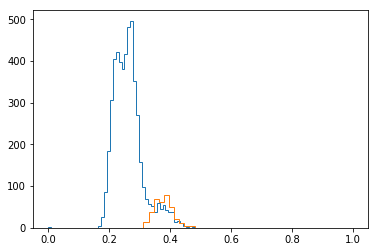

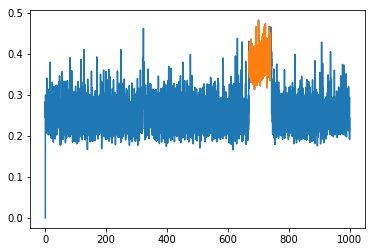

<Figure size 432x288 with 0 Axes>

In [99]:
minor_state_frames=np.where((time>670) & (time<740))
minor_state_frames
major_state_frames=np.where((time<670) & (time>740))


rmsd_minor=rmsd[minor_state_frames]
rmsd_major=rmsd[major_state_frames]


plt.hist(rmsd,histtype='step',bins=50)
plt.hist(rmsd_minor,histtype='step')
plt.hist(rmsd_major,histtype='step')
plt.show()
plt.clf()
plt.plot(time,rmsd)
plt.plot(time[minor_state_frames],rmsd[minor_state_frames])
plt.show()
plt.clf()

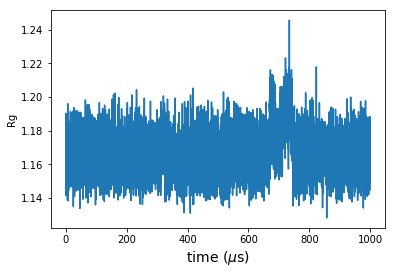

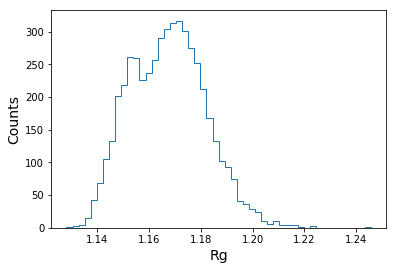

In [18]:
#Lets calculate the radius of gyration and make a histogram
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

In [19]:
#Lets identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))
    

MET1-N -- VAL17-O
MET1-N -- VAL17-O
MET1-N -- VAL17-O
ILE3-N -- LEU15-O
PHE4-N -- SER65-O
VAL5-N -- ILE13-O
LYS6-N -- LEU67-O
THR7-N -- LYS11-O
LEU8-N -- THR7-OG1
LEU8-N -- LEU69-O
THR9-N -- THR7-OG1
GLY10-N -- THR7-O
LYS11-N -- THR7-OG1
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
ILE13-N -- VAL5-O
LEU15-N -- ILE3-O
VAL17-N -- MET1-O
GLU18-N -- ASP21-OD1
GLU18-N -- ASP21-OD2
ASP21-N -- GLU18-O
THR22-N -- ASN25-OD1
ILE23-N -- ARG54-O
GLU24-N -- ASP52-O
ASN25-N -- THR22-OG1
ASN25-N -- THR22-O
ASN25-ND2 -- THR22-OG1
ASN25-ND2 -- THR22-OG1
VAL26-N -- THR22-O
VAL26-N -- ILE23-O
LYS27-N -- ILE23-O
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
ALA28-N -- GLU24-O
LYS29-N -- ASN25-O
LYS29-N -- VAL26-O
ILE30-N -- VAL26-O
ILE30-N -- LYS27-O
GLN31-N -- LYS27-O
ASP32-N

In [20]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[  0   1 285] MET1-N VAL17-O
[  0   2 285] MET1-N VAL17-O
[  0   3 285] MET1-N VAL17-O
[ 36  37 254] ILE3-N LEU15-O
[  55   56 1044] PHE4-N SER65-O
[ 75  76 221] VAL5-N ILE13-O
[  91   92 1077] LYS6-N LEU67-O
[113 114 188] THR7-N LYS11-O
[127 128 119] LEU8-N THR7-OG1
[ 127  128 1113] LEU8-N LEU69-O
[146 147 119] THR9-N THR7-OG1
[160 161 126] GLY10-N THR7-O
[167 168 119] LYS11-N THR7-OG1
[183 184 551] LYS11-NZ GLU34-OE1
[183 184 552] LYS11-NZ GLU34-OE2
[183 185 551] LYS11-NZ GLU34-OE1
[183 185 552] LYS11-NZ GLU34-OE2
[183 186 551] LYS11-NZ GLU34-OE1
[183 186 552] LYS11-NZ GLU34-OE2
[203 204  90] ILE13-N VAL5-O
[236 237  54] LEU15-N ILE3-O
[270 271  18] VAL17-N MET1-O
[286 287 334] GLU18-N ASP21-OD1
[286 287 335] GLU18-N ASP21-OD2
[326 327 300] ASP21-N GLU18-O
[338 339 394] THR22-N ASN25-OD1
[352 353 869] ILE23-N ARG54-O
[371 372 838] GLU24-N ASP52-O
[386 387 344] ASN25-N THR22-OG1
[386 387 351] ASN25-N THR22-O
[395 396 344] ASN25-ND2 THR22-OG1
[395 397 344] ASN25-ND2 THR22-OG1
[400 401 

[  55   56 1044] PHE4-N SER65-O


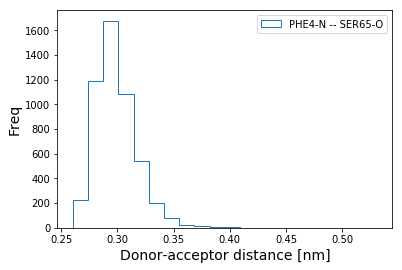

In [21]:
Hbond_index=4
hbond=hbonds[Hbond_index]
donor = top.atom(hbond[0])
acc = top.atom(hbond[2])
print(hbond,donor,acc)

da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)
plt.hist(da_distance,histtype='step',bins=20, label=label(hbonds[Hbond_index]))
#for i in [2, 3, 4]:
#    plt.hist(da_distances[:, i], color=next(color),histtype='step',bins=10, label=label(hbonds[i]), alpha=0.5)
plt.legend()
plt.ylabel('Freq',size=14);
plt.xlabel('Donor-acceptor distance [nm]',size=14)
plt.show()

***We're going to run a Principle Component Analysis (PCA)***

This takes the variance of the cartesian coordinates of each atom over the course of the trajectory and finds "projections" that explain as much of variance as posisble.

https://en.wikipedia.org/wiki/Principal_component_analysis

In [22]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(5044, 2)


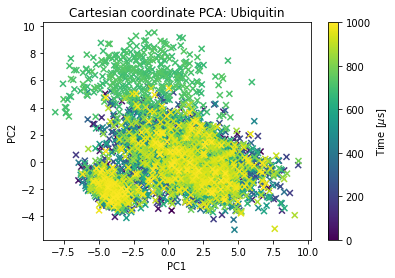

In [23]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')

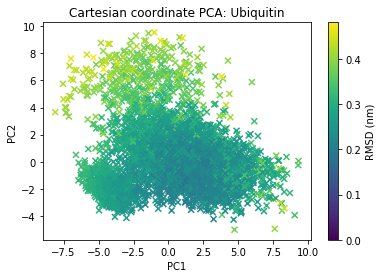

In [24]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

C:\Users\leman\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


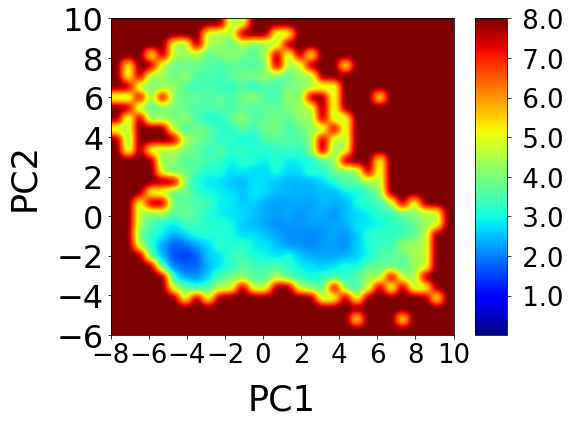

In [25]:
###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

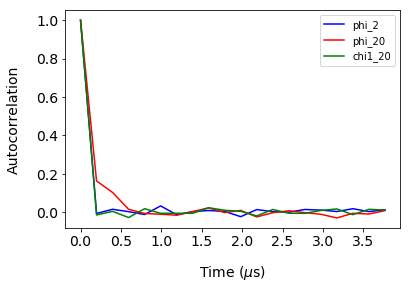

(20,)
(20,)


In [48]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(20)
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['phi'][2],lags)
phi20_acf=autocorr1(dihedral_dict['phi'][20],lags)
chi20_acf=autocorr1(dihedral_dict['chi1'][20],lags)

plt.plot(time[lags],phi2_acf,color='b',label='phi_2')
plt.plot(time[lags],phi20_acf,color='r',label='phi_20')
plt.plot(time[lags],chi20_acf,color='g',label='chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()
print(np.shape(time[lags]))
print(np.shape(phi2_acf))

In [35]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []
for i in range(1, 76):
    contact_map = []
    contact_distance = []
    for j in range(1, 76):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)
print(final_map)
print(final_distance)

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]
[[0.13465609 0.39935951 0.77012882 ... 2.3653492  2.5319635  2.48091734]
 [0.13465609 0.13461967 0.40990796 ... 2.09404928 2.3605738  2.35196827]
 [0.39935951 0.13461967 0.13458808 ... 2.07096957 2.33344948 2.35302034]
 ...
 [2.3653492  2.09404928 2.07096957 ... 0.13485488 0.13502981 0.35557672]
 [2.5319635  2.3605738  2.33344948 ... 0.39234836 0.13502981 0.13429917]
 [2.48091734 2.35196827 2.35302034 ... 0.59371812 0.35557672 0.13429917]]


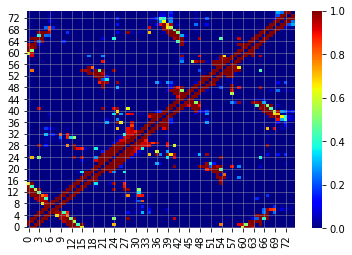

In [28]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)


Lets think about some fun things we can do with this trajectory.  

Rubric (Completing the bolded tasks and attempting some additional tasks puts an assignment in the ~"P - B/B+" range, attempting and completing some additional more advanced tasks will earn a ~"HP - A/A-").  Very parital or incomplete attempts for the bolded questiosn is in the ~"LP / B-/C+"

Ideas:

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?** 

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

  More Advanced:
  
  2a) Can you calculate/ fit the correlation times? 
  
  2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? 

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why?

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.

7) Compare the contact maps, dihedral correlations, and hydrogen bond populations for different subsets of PC space (ie PC1 is on the intevral [lower1,upper1] and PC2 is on the invertval [lower2,upper2]

7) Compute an visualize all-to-all RMSD calculation of the frames of this trajectory.  

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples)


9) Visualize the most populated clusters from your clustering analysis

Here is the equation used to calculate circular correlation coefficients for dihedral angles

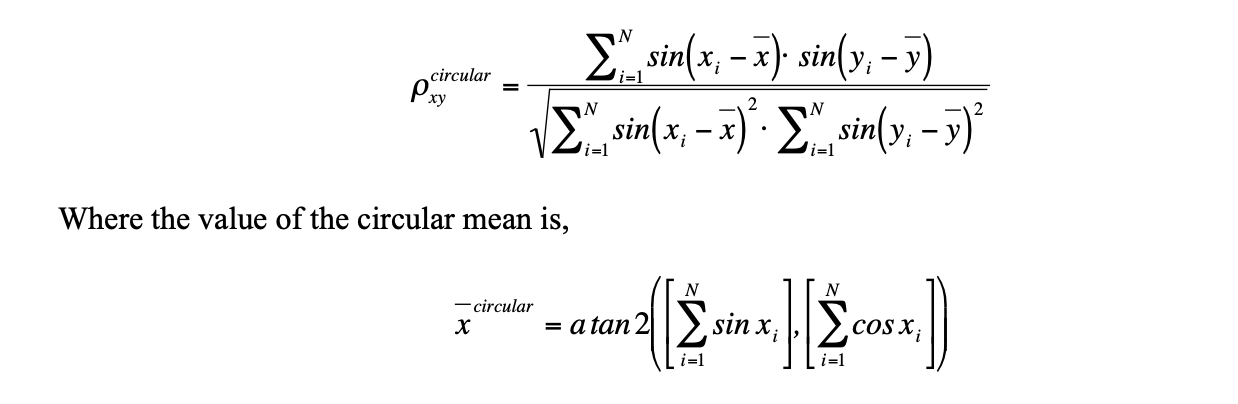


Lets calculate some correlations between dihedrals found in the paper: 


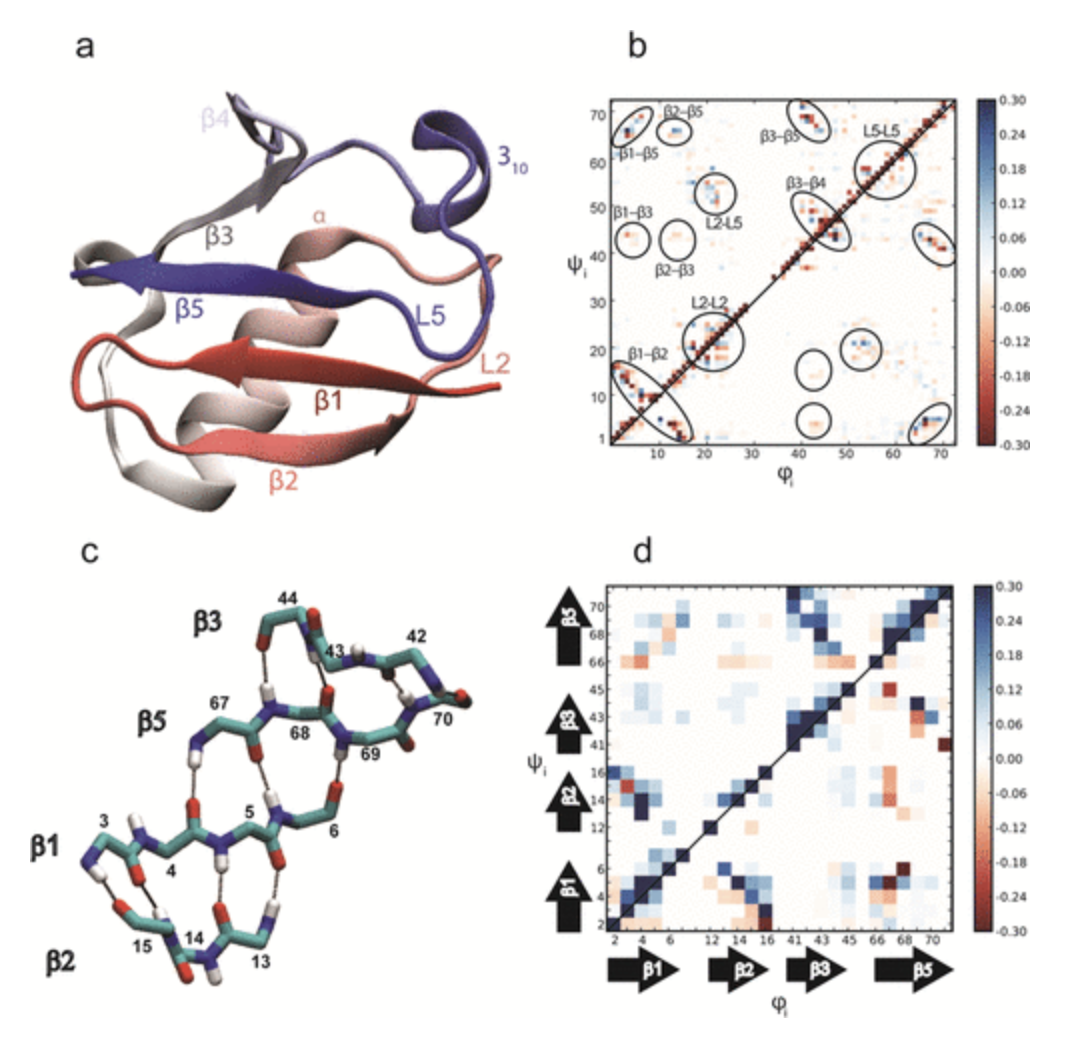

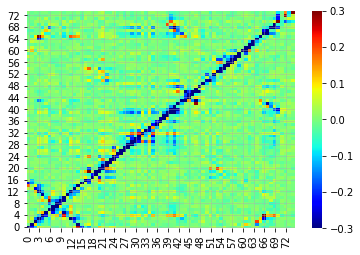

In [141]:
#Question 4:

def calc_circular_mean(angles):
    sum_sin = 0
    sum_cos = 0
    for a in angles:
        sum_sin += np.sin(a)
        sum_cos += np.cos(a)
    return math.atan2(sum_sin,sum_cos)

def calc_circ_corr_coeff(angles1,angles2):
    a1_mean=calc_circular_mean(angles1)
    a2_mean=calc_circular_mean(angles2)
    numerator_a1_array=[]
    numerator_a2_array=[]
    numerator=0
    denominator_left=0
    denominator_right=0
    for a1 in angles1:
        numerator_a1_array.append(np.sin(a1-a1_mean))
        denominator_left+=(np.sin(a1-a1_mean))**2
    for a2 in angles2:
        numerator_a2_array.append(np.sin(a2-a2_mean))
        denominator_right+=(np.sin(a2-a2_mean))**2
    numerator_array = np.column_stack((numerator_a1_array,numerator_a2_array))
    for an in numerator_array:
        numerator+=np.sin(an[0])*np.sin(an[1])
    return numerator/(denominator_left*denominator_right)**0.5

#Lets Make a Correlation Map
#correlation_maps = []
correlation_coeffs = []
for i in range(2, 76):#calculating for all phi angles (i.e. residues 2-76)
    #correlation_map = []
    correlation_coeff = []
    for j in range(1, 76):#calculating for all psi angles (i.e. residues 1-75)
        corr = calc_circ_corr_coeff(dihedral_dict['phi'][i],dihedral_dict['psi'][j])
        #dist = md.compute_contacts(trj, [[i, j]])
        #array = np.asarray(dist[0]).astype(float)
        #distance = np.average(array)
        correlation_coeff.append(corr)
        #contact = np.where(array < 0.5, 1, 0)
        #contacts = np.average(contact)
        #contact_map.append(contacts)
    correlation_coeffs.append(correlation_coeff)
    #contact_distances.append(contact_distance)
#final_map = np.asarray(contact_maps).astype(float)
final_corr = np.asarray(correlation_coeffs).astype(float)

ax = sns.heatmap(final_corr, vmin=-0.3, vmax=0.3,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)


[[-0.57144145 -0.23427398 -0.10127218 ... -0.00615259 -0.02011356
  -0.00150954]
 [-0.00795027 -0.57851455  0.10455387 ... -0.00937758  0.00719838
   0.00168512]
 [ 0.04479731  0.00707076 -0.68671433 ... -0.01101473  0.00107004
  -0.00656538]
 ...
 [-0.0049469  -0.00072895 -0.00512127 ...  0.01377816  0.05989833
   0.05154187]
 [-0.02340618 -0.00930353 -0.01837029 ...  0.28432177 -0.07101402
   0.05949546]
 [ 0.00616645 -0.01577596 -0.00259339 ...  0.15777909 -0.09451794
   0.34612136]]
[[-0.57144145 -0.23427398 -0.10127218 ...  0.          0.
   0.        ]
 [-0.00795027 -0.57851455  0.10455387 ... -0.00937758  0.00719838
   0.00168512]
 [ 0.04479731  0.00707076 -0.68671433 ... -0.01101473  0.00107004
  -0.00656538]
 ...
 [-0.0049469  -0.00072895 -0.00512127 ...  0.01377816  0.05989833
   0.05154187]
 [-0.02340618 -0.00930353 -0.01837029 ...  0.28432177 -0.07101402
   0.05949546]
 [ 0.00616645 -0.01577596 -0.00259339 ...  0.15777909 -0.09451794
   0.34612136]]


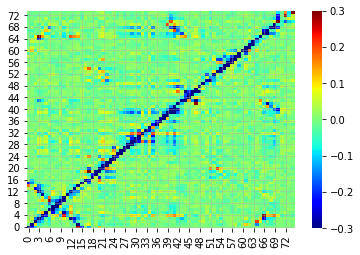

In [155]:
#Create a masked array for the heat map.
mask = final_corr.copy()
#Seems to be some sort of bug in my loop that's causing the mask to not work.
iy = 0
ix = 0
while(iy < len(final_corr)):
    while(ix < len(final_corr[iy])):
        if ((final_corr[iy][ix] < 0.10) and (final_corr[iy][ix] > -0.10)):
             mask[iy][ix] = 0
        ix += 1
    iy += 1

print(final_corr)
print(mask)

ax = sns.heatmap(mask, vmin=-0.3, vmax=0.3,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)

[0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 3.767598651596272, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 3.767598651596272, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.793178663493952, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.198294665873488, 0.396589331746976, 0.198294665

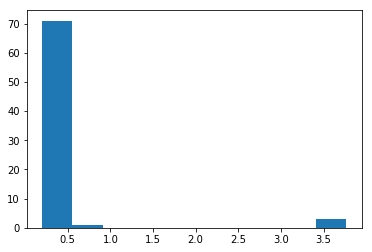

<Figure size 432x288 with 0 Axes>

In [94]:
#Question 2:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)

time=np.linspace(0,1000,trj.n_frames)
lags=range(20)

#Question 2a
#Return last time before it falls below the correlation value as the correlation
#time.
def calc_corr_time(corrs,times):
    i = 0
    corr_value = 1/math.e
    #print(len(corrs))
    #print(corrs)
    while(i < len(corrs) and corrs[i] >= corr_value):
        i = i + 1
        #print(i)
    if(i == len(corrs)):
        return times[i - 1]
    else:
        return times[i]
    

#Now calculate the correlation times of all phi dihedrals and plot into hist.
#This way, we can figure out what some of the longer correlation times will be.

phis=[]
for phi_a in dihedral_dict['phi']:
    auto_time = autocorr1(dihedral_dict['phi'][phi_a],lags)
    phis.append(auto_time)
    
#print(1/math.e)
#print(phis)

phi_corr = []
for res in phis:
    auto_time = calc_corr_time(res,time[lags])
    phi_corr.append(auto_time)

print(phi_corr)
plt.hist(phi_corr)
plt.show()
plt.clf()

In [106]:
#Question 2b:
def id_corr_time(thresh):
    longer = []
    for ang_typ in dihedral_dict:
    #print(ang_typ)
        for res in dihedral_dict[ang_typ]:
            auto_t = autocorr1(dihedral_dict[ang_typ][res],lags)
            corr_t = calc_corr_time(auto_t,time[lags])
            if(corr_t > thresh):
                longer.append([ang_typ,res,corr_t])
    return longer

#All correlation times longer than the first tick is what we're finding here.
good_corrs = id_corr_time(0.198294665873488)
for res in good_corrs:
    print(res[0],res[1],", correlation time: ", res[2])

phi 10 , correlation time:  3.767598651596272
phi 35 , correlation time:  3.767598651596272
phi 40 , correlation time:  0.793178663493952
phi 53 , correlation time:  0.396589331746976
phi 60 , correlation time:  3.767598651596272
psi 8 , correlation time:  0.99147332936744
psi 9 , correlation time:  1.586357326987904
psi 13 , correlation time:  3.767598651596272
psi 30 , correlation time:  3.767598651596272
psi 31 , correlation time:  3.767598651596272
psi 32 , correlation time:  3.767598651596272
psi 33 , correlation time:  2.97441998810232
psi 34 , correlation time:  3.767598651596272
psi 39 , correlation time:  0.793178663493952
psi 51 , correlation time:  1.586357326987904
psi 59 , correlation time:  3.3710093198492963
chi2 59 , correlation time:  0.99147332936744


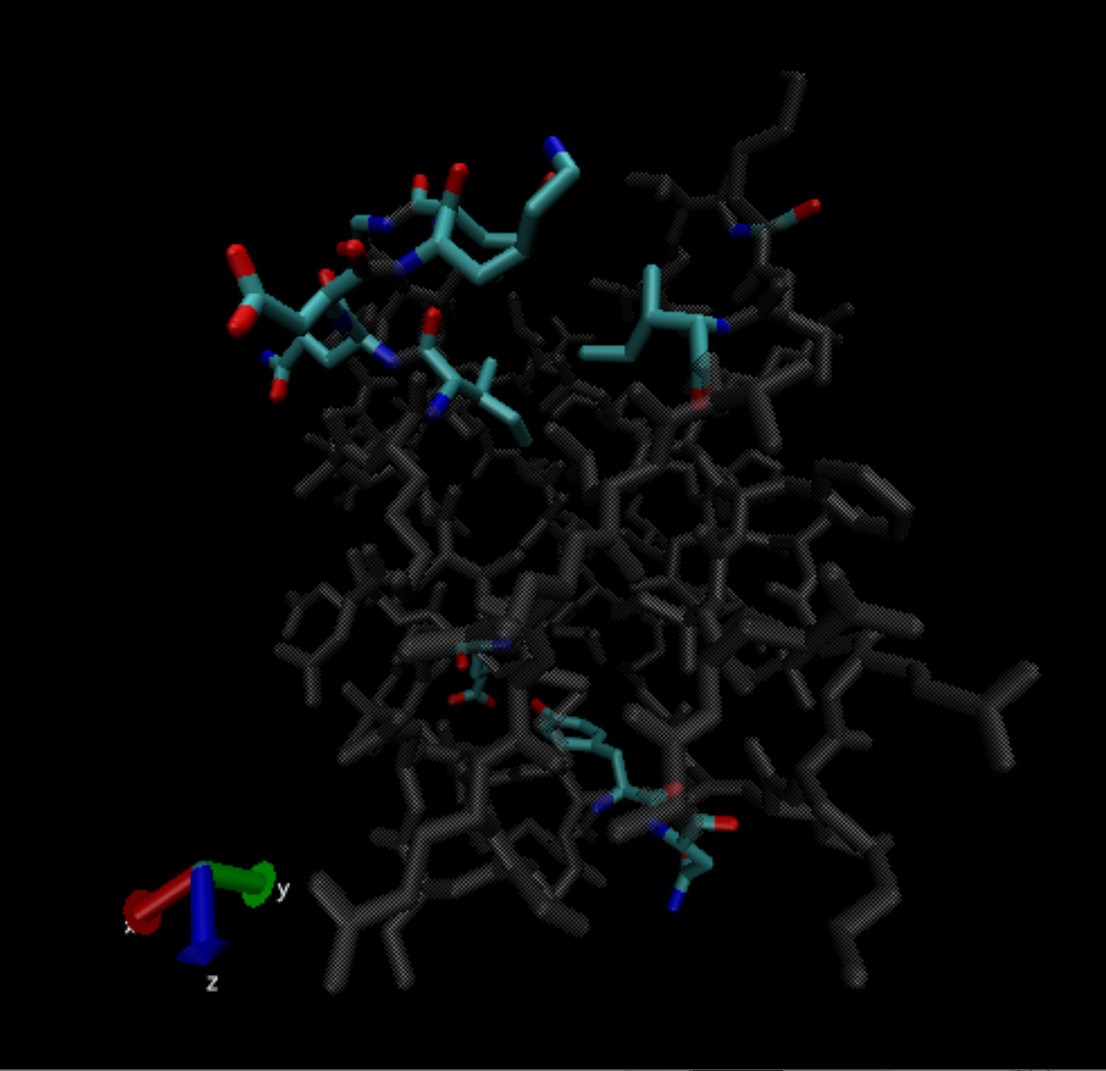

In [128]:
#Question 2
#As we can see from above, there are quite a few dihedral angles with longer
#correlation times. I would consider those dihedral angles with correlation
#times longer than 1.5 microseconds to have a long correlation time.
#Specifically, those are residues 8, 9, 10, 13, 30, 31, 32, 33, 34, 35. 51, and 59
#What I did was to visualize those residues in frame 4300 using elemental colors.
#I kept the rest of the structure a transparent gray.
#From what we can see, these residues typically have their side chains sticking
#out into empty space or into relatively empty parts of the the protein.
#This means that these residues' side chains are subject to less steric
#interactions with the other parts of the protein, meaning that they
#will not often undergo impacts that twist them from their positions.
#This means that the protein back bones for these residues will also not really
#be twisted that often, so their correlation times for their dihedral angles
#will be higher.

from IPython.display import Image

#First image. Notice that the side chains pointing towards the center on top are
#not really close to any other sources of steric hinderance.
Image("Question_2_1.PNG")

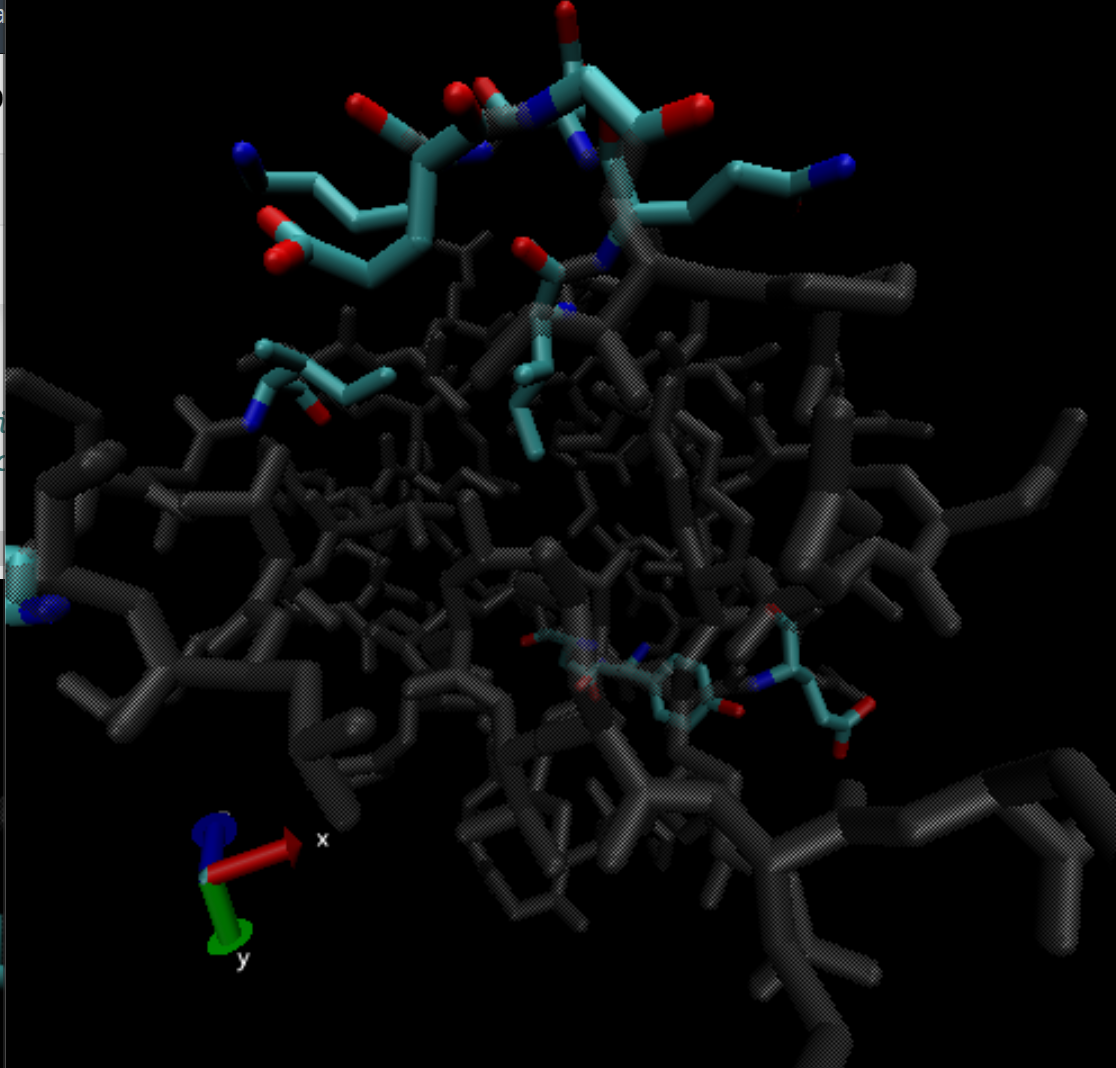

In [130]:
#Second image. Notice that on the top, side chains that do exist point off into
#empty space.

Image("Question_2_2.PNG")

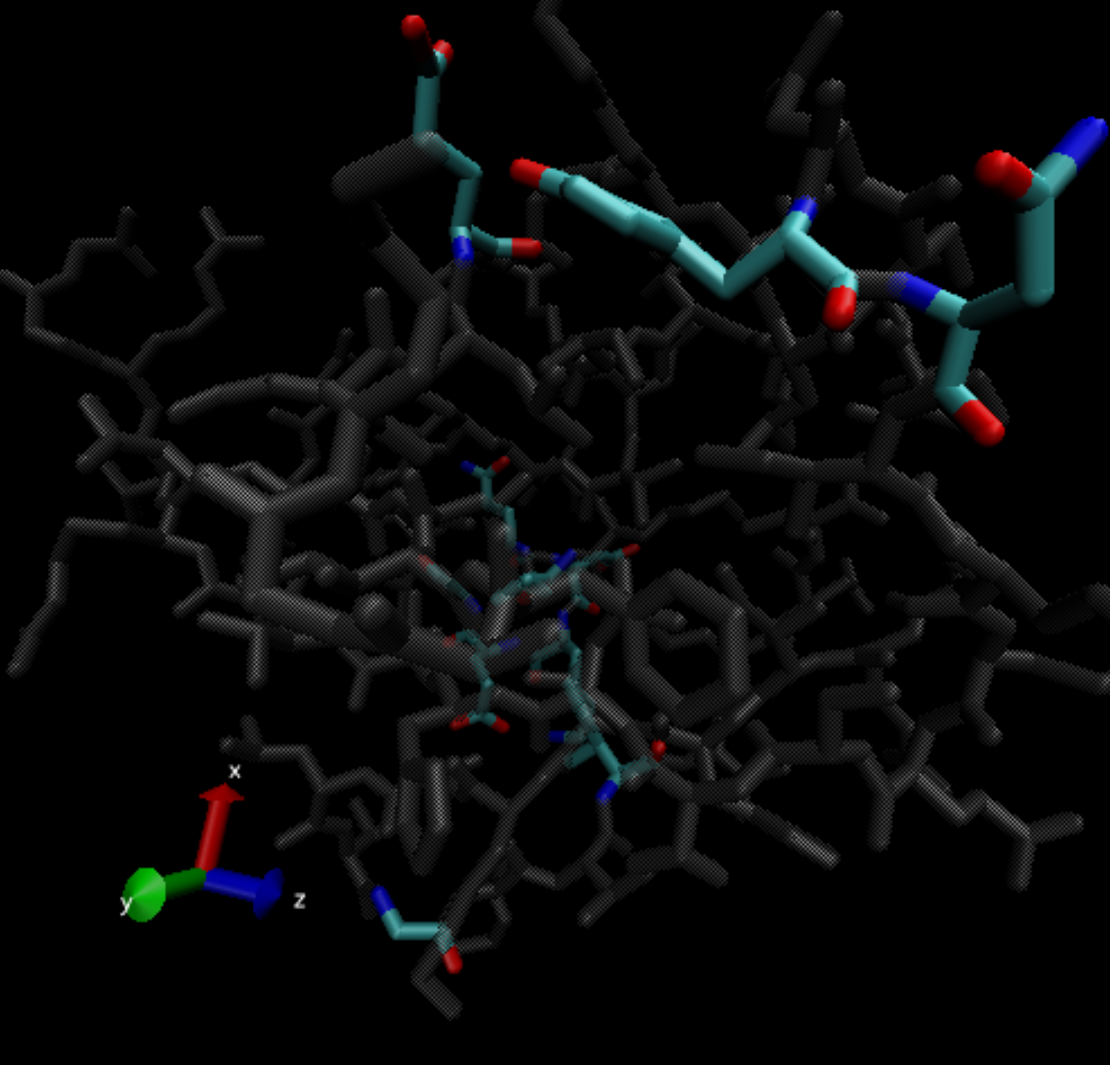

In [131]:
#Third image. Other side of protein. Notice that it's the same deal.
#Side chains either point off into empty space or relatively sterically
#unhindered parts of the protein.

Image("Question_2_3.PNG")

Question 1: As we can see in the visualization of the two states below, part of the purple alpha helix uncurls, and we obtain our structural differences that make the "minor state" structurally different.

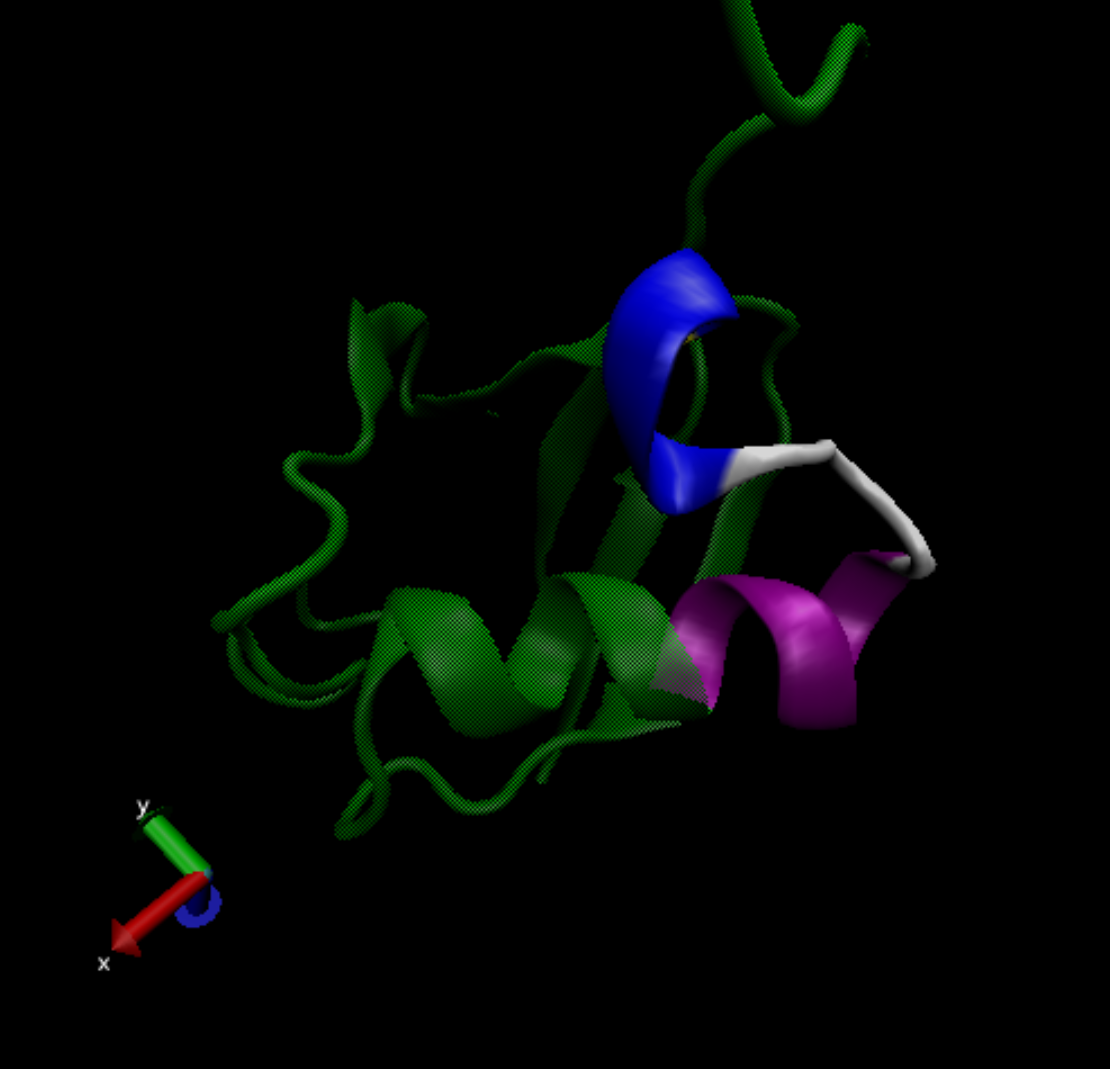

In [126]:
#Image from frame 6410, before uncurling. The major state.
Image("Question_1_Major.PNG")

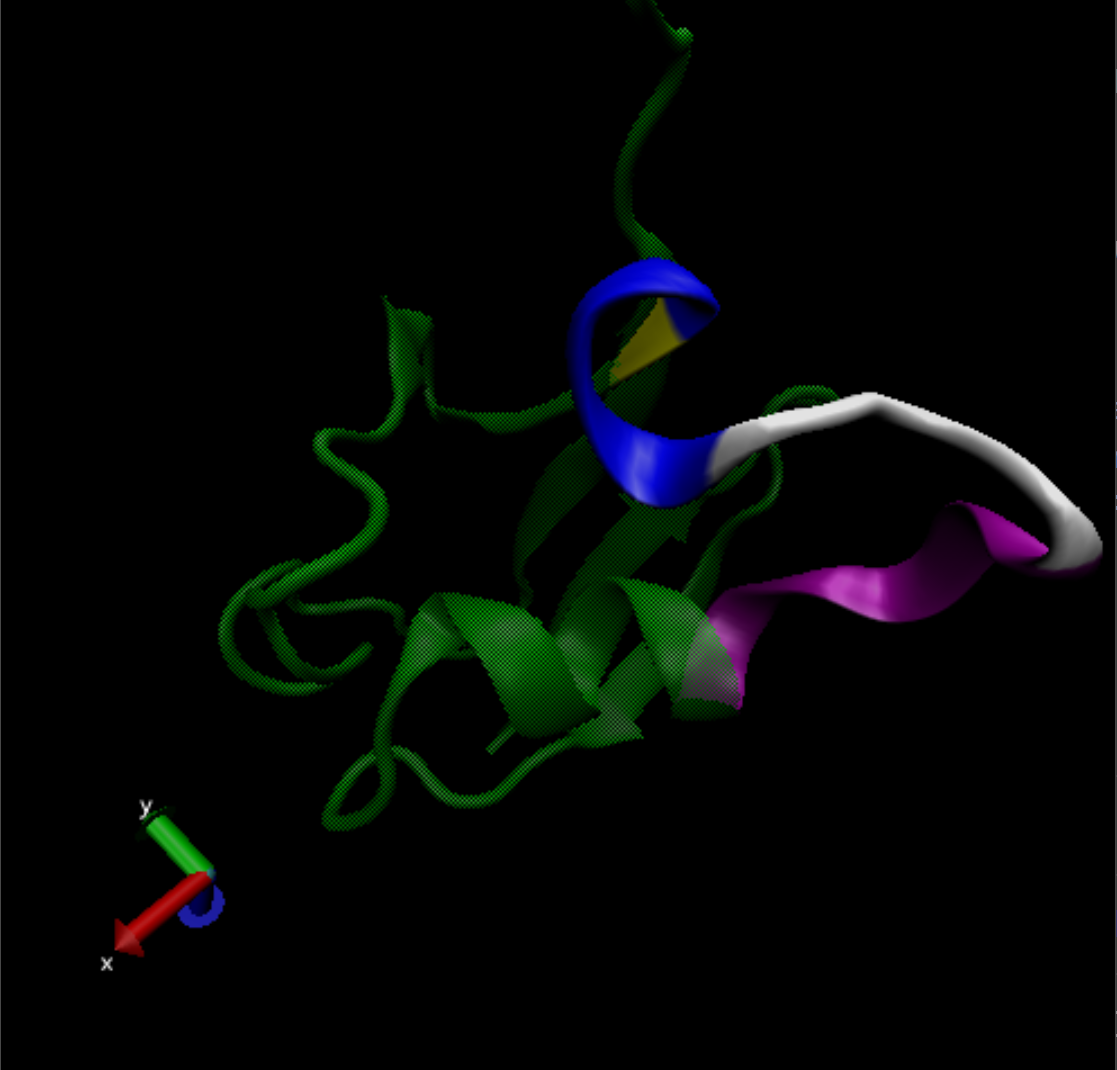

In [127]:
#Image from frame 6843, after uncurling. The minor state.
Image("Question_1_Minor.PNG")

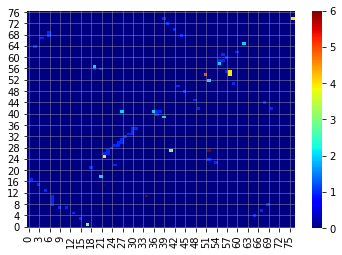

In [124]:
#Question 5
#regex code to get numbers was from https://stackoverflow.com/questions/10365225/extract-digits-in-a-simple-way-from-a-python-string
import re

hbonds = md.baker_hubbard(trj, periodic=False)

donors = []
acceptors = []
#Array where the donors are the rows and acceptors are the columns.
hbond_map = np.zeros((77,77))
for hbond in hbonds:
    donor = str(top.atom(hbond[0]))
    donor_num = int(re.findall('\d+',donor.split()[0])[0])
    acc = str(top.atom(hbond[2]))
    acc_num = int(re.findall('\d+',acc.split()[0])[0])
    #print(donor_num," ",acc_num)
    hbond_map[donor_num,acc_num] = hbond_map[donor_num,acc_num] + 1
 
ax = sns.heatmap(hbond_map,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)

